In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import wrangle
import evaluate

pd.options.display.max_columns = None

In [39]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression

The Plan:
- Parametric model age to structure value
- Linear model structure sqft to structure value
- Linear model structure value to tax value.
- Predict in sequence for final prediction

In [40]:
train, test, validate = wrangle.wrangle_zillow()

# Baselines

#### Baseline 1 - Structure value

In [41]:
base_home = train.tax_structure.mean()
base_home

178415.13240592473

#### Baseline 1 - Total value

In [42]:
base_total = train.tax.mean()
base_total

474281.16986922873

# Ensemble 1

### Part 1:  Age for Structure value

In [43]:
x1_train = train[['age','age']] # PolynomialFeatures only accepts 2d arrays, so duplicate the column.
y1_train = train.tax_structure
x1_train

,age,age
19177,64,64
31614,59,59
41666,63,63
40702,56,56
3541,43,43
...,...,...
10747,93,93
36141,90,90
19062,65,65
26838,59,59


In [44]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=False)
x1_train_p = poly.fit_transform(x1_train)

In [45]:
model1 = LinearRegression(positive=False)
model1.fit(x1_train_p, y1_train)


LinearRegression()

In [46]:
train_pred = model1.predict(x1_train_p)
baseline = np.full_like(y1_train, y1_train.mean())

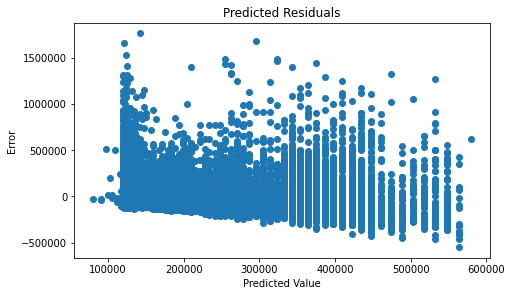

In [47]:
evaluate.plot_residuals(y1_train, train_pred)

In [48]:
model1.coef_

array([-2.75621893e+06,  2.73951755e+06,  5.45713686e+09, -2.72856833e+09,
       -2.72856833e+09, -5.54223658e+11, -1.22503553e+11,  3.38116941e+11,
        3.38610269e+11])

This model alone predicts $24,154 closer on average.

In [49]:
def get_model1_x_x2_y(df, poly):
    x = df[['age','age']]
    x2 = poly.transform(x)
    y = df.tax_structure
    return x, x2, y

x1_test, x1_test_p, y1_test = get_model1_x_x2_y(test, poly)
x1_test.shape, x1_test_p.shape, y1_test.shape

((10149, 2), (10149, 9), (10149,))

In [50]:
print(evaluate.baseline_mean_errors(y1_train)['RMSE'] , evaluate.regression_errors(y1_train, train_pred)['RMSE'])
print(evaluate.baseline_mean_errors(y1_train)['RMSE'] - evaluate.regression_errors(y1_train, train_pred)['RMSE'])

171629.99659044223 147063.68466499535
24566.311925446877


In [51]:
test_pred = model1.predict(x1_test_p)
print( evaluate.baseline_mean_errors(y1_test)['RMSE'],  evaluate.regression_errors(y1_test, test_pred)['RMSE']) 
print( evaluate.baseline_mean_errors(y1_test)['RMSE'] -  evaluate.regression_errors(y1_test, test_pred)['RMSE']) 

229043.18615762182 208216.33579624587
20826.850361375953


### Part 2:  Structure Square Feet for Structure value

In [52]:
def get_model2_x_y(df):
    x = df[['structure_sqft','structure_sqft']]
    y = df.tax_structure
    return x, y

x2_train, y2_train = get_model2_x_y(train)
x2_test, y2_test = get_model2_x_y(test)

In [53]:
model2= LinearRegression(positive=True)
model2.fit(x2_train, y2_train)


LinearRegression(positive=True)

In [54]:
train_pred2 = model2.predict(x2_train)
test_pred2 = model2.predict(x2_test)

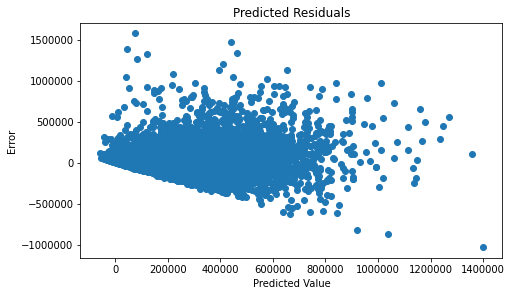

In [55]:
evaluate.plot_residuals(y2_train, train_pred2)

In [56]:
print('Train')
print(evaluate.baseline_mean_errors(y2_train)['RMSE'] , evaluate.regression_errors(y2_train, train_pred2)['RMSE'])
print(evaluate.baseline_mean_errors(y2_train)['RMSE'] - evaluate.regression_errors(y2_train, train_pred2)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y2_test)['RMSE'],  evaluate.regression_errors(y2_test, test_pred2)['RMSE']) 
print( evaluate.baseline_mean_errors(y2_test)['RMSE'] -  evaluate.regression_errors(y2_test, test_pred2)['RMSE']) 

Train
171629.99659044223 108387.37560485641
63242.62098558582
Test
229043.18615762182 151073.14081621607
77970.04534140576


### Bringing them together

In [57]:
mean_pred_train = (train_pred + train_pred2)/2
mean_pred_test = (test_pred + test_pred2)/2

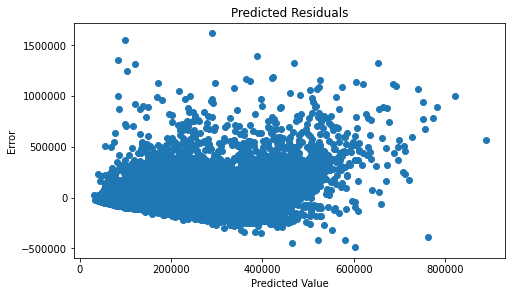

In [58]:
evaluate.plot_residuals(y1_train, mean_pred_train)

In [59]:
print('RMSE for average of two models')
print('Train')
print(evaluate.baseline_mean_errors(train.tax_structure)['RMSE'] , evaluate.regression_errors(train.tax_structure, mean_pred_train)['RMSE'])
print(evaluate.baseline_mean_errors(train.tax_structure)['RMSE'] - evaluate.regression_errors(train.tax_structure, mean_pred_train)['RMSE'])
print('Test')
print(evaluate.baseline_mean_errors(test.tax_structure)['RMSE'] , evaluate.regression_errors(test.tax_structure, mean_pred_test)['RMSE'])
print(evaluate.baseline_mean_errors(test.tax_structure)['RMSE'] - evaluate.regression_errors(test.tax_structure, mean_pred_test)['RMSE'])


RMSE for average of two models
Train
171629.99659044223 115041.37269051388
56588.62389992835
Test
229043.18615762182 169751.3438657634
59291.842291858426


### Part 3:  Predicting overall tax value from predicted structure value

In [60]:
def get_model3_x_y(df):
    x = df[['tax_structure','tax_structure']]
    y = df.tax
    return x, y

In [61]:
x3_train, y3_train = get_model3_x_y(train)
x3_test, y3_test = get_model3_x_y(test)

In [62]:
model3= LinearRegression(positive=True)
model3.fit(x3_train, y3_train)

LinearRegression(positive=True)

In [63]:
train_pred3 = model3.predict(x3_train)
test_pred3 = model3.predict(x3_test)

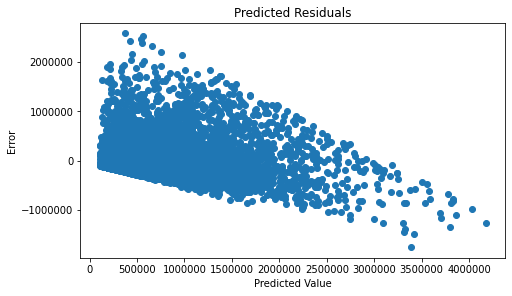

In [64]:
evaluate.plot_residuals(y3_train, train_pred3)


In [65]:
print('Train')
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] , evaluate.regression_errors(y3_train, train_pred3)['RMSE'])
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] - evaluate.regression_errors(y3_train, train_pred3)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y3_test)['RMSE'],  evaluate.regression_errors(y3_test, test_pred3)['RMSE']) 
print( evaluate.baseline_mean_errors(y3_test)['RMSE'] -  evaluate.regression_errors(y3_test, test_pred3)['RMSE']) 

Train
436833.46071328287 256879.93607101435
179953.52464226852
Test
617618.0397732955 360989.5890395086
256628.4507337869


In [66]:
pd.concat((pd.DataFrame(mean_pred_train),pd.DataFrame(mean_pred_train)),axis=1)

,0,0
0,101514.623136,101514.623136
1,131720.943623,131720.943623
2,147459.267314,147459.267314
3,166062.775453,166062.775453
4,151880.840055,151880.840055
...,...,...
29971,72529.034032,72529.034032
29972,160294.775453,160294.775453
29973,102671.700812,102671.700812
29974,150989.597415,150989.597415


In [67]:
train_pred3_p = model3.predict(pd.concat((pd.DataFrame(mean_pred_train),pd.DataFrame(mean_pred_train)),axis=1))
test_pred3_p = model3.predict(pd.concat((pd.DataFrame(mean_pred_test),pd.DataFrame(mean_pred_test)),axis=1))
print('Train')
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] , evaluate.regression_errors(y3_train, train_pred3_p)['RMSE'])
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] - evaluate.regression_errors(y3_train, train_pred3_p)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y3_test)['RMSE'],  evaluate.regression_errors(y3_test, test_pred3_p)['RMSE']) 
print( evaluate.baseline_mean_errors(y3_test)['RMSE'] -  evaluate.regression_errors(y3_test, test_pred3_p)['RMSE']) 

Train
436833.46071328287 365286.1039618375
71547.35675144539
Test
617618.0397732955 531449.342836396
86168.69693689956


c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


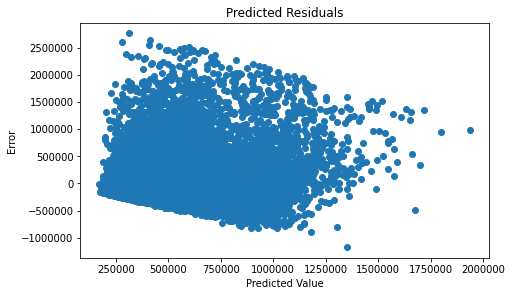

In [68]:
evaluate.plot_residuals(y3_train, train_pred3_p)

## Model 2

### Try sqft, age, bathroom_sum together

In [69]:
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train[['age','structure_sqft','bathroom_sum']])
train_x = pd.DataFrame(train_x, columns=['age','structure_sqft','bathroom_sum'])
train_x

,age,structure_sqft,bathroom_sum
0,0.470149,0.094718,0.111111
1,0.432836,0.131836,0.111111
2,0.462687,0.156997,0.222222
3,0.410448,0.175296,0.222222
4,0.313433,0.128925,0.111111
...,...,...,...
29971,0.686567,0.054065,0.000000
29972,0.664179,0.175296,0.111111
29973,0.477612,0.096902,0.111111
29974,0.432836,0.158245,0.111111


In [70]:
poly = PolynomialFeatures(3)
age = np.array(train_x.age)
age = age.reshape((age.shape[0], 1))
age.shape, train.structure_sqft.shape

age_poly = poly.fit_transform(age)
age_poly = pd.DataFrame(age_poly)
age_poly


,0,1,2,3
0,1.0,0.470149,0.221040,0.103922
1,1.0,0.432836,0.187347,0.081090
2,1.0,0.462687,0.214079,0.099051
3,1.0,0.410448,0.168467,0.069147
4,1.0,0.313433,0.098240,0.030792
...,...,...,...,...
29971,1.0,0.686567,0.471374,0.323630
29972,1.0,0.664179,0.441134,0.292992
29973,1.0,0.477612,0.228113,0.108950
29974,1.0,0.432836,0.187347,0.081090


In [71]:
train_x = train_x.drop(columns='age')
train_x = pd.concat((train_x,age_poly), axis=1)
train_x

,structure_sqft,bathroom_sum,0,1,2,3
0,0.094718,0.111111,1.0,0.470149,0.221040,0.103922
1,0.131836,0.111111,1.0,0.432836,0.187347,0.081090
2,0.156997,0.222222,1.0,0.462687,0.214079,0.099051
3,0.175296,0.222222,1.0,0.410448,0.168467,0.069147
4,0.128925,0.111111,1.0,0.313433,0.098240,0.030792
...,...,...,...,...,...,...
29971,0.054065,0.000000,1.0,0.686567,0.471374,0.323630
29972,0.175296,0.111111,1.0,0.664179,0.441134,0.292992
29973,0.096902,0.111111,1.0,0.477612,0.228113,0.108950
29974,0.158245,0.111111,1.0,0.432836,0.187347,0.081090


In [72]:
model4 = LinearRegression(positive=True)
train_y = train.tax

model4.fit(train_x, train_y)
train_pred4 = model4.predict(train_x)

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


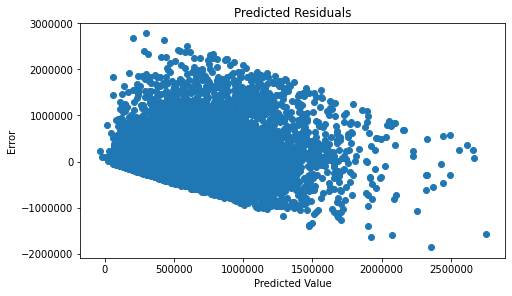

In [73]:
evaluate.plot_residuals(train_y, train_pred4)

In [74]:
print(evaluate.baseline_mean_errors(train_y)['RMSE'] , evaluate.regression_errors(train_y, train_pred4)['RMSE'])
print(evaluate.baseline_mean_errors(train_y)['RMSE'] - evaluate.regression_errors(train_y, train_pred4)['RMSE'])

436833.46071328287 344404.1221363806
92429.33857690229


In [ ]:
def reshape_series(series):
    """For getting a 2D array from a pandas series. Useful for univariate models."""
    x = np.array(series)
    x = x.reshape((x.shape[0], 1))
    return x

## Model 3: Simpler Ensemble

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def reshape_series(series):
    """For getting a 2D array from a pandas series. Useful for univariate models."""
    x = np.array(series)
    x = x.reshape((x.shape[0], 1))
    return x

def reshape_array(x):
    """For getting a 2D array from a 1D array. Useful for univariate models."""
    x = x.reshape((x.shape[0], 1))
    return x

def train_baseline_match_len(predictions):
    ybar = train.tax.mean()
    baseline = np.full_like(predictions, ybar)
    return baseline

train, test, validate = wrangle.wrangle_zillow()

x1 = reshape_series(train.structure_sqft)
x2 = reshape_series(train.tax_structure)
y1 = train.tax_structure
y2 = train.tax

model1 = LinearRegression(positive=False)
model1.fit(x1, y1)

model2 = LinearRegression(positive=False)
model2.fit(x2,y2)

def ensemble_predict(d2array, m1=model1, m2=model2):
    p1 = m1.predict(d2array)
    p1 = reshape_array(p1)
    p2 = m2.predict(p1)
    return p2

In [ ]:
x_train = reshape_series(train.structure_sqft)
y_train = train.tax
x_test = reshape_series(test.structure_sqft)
y_test = test.tax
x_validate = reshape_series(validate.structure_sqft)
y_validate = validate.tax

In [ ]:
train_pred = ensemble_predict(x_train)
test_pred = ensemble_predict(x_test)
validate_pred = ensemble_predict(x_validate)

In [ ]:
train_pred_RMSE = mean_squared_error(y_train, train_pred, squared=False)
test_pred_RMSE = mean_squared_error(y_test, test_pred, squared=False)
validate_pred_RMSE = mean_squared_error(y_validate, validate_pred, squared=False)

In [ ]:
train_base = train_baseline_match_len(y_train)
test_base = train_baseline_match_len(y_test)
validate_base = train_baseline_match_len(y_validate)

train_base_RMSE = mean_squared_error(y_train, train_base, squared=False)
test_base_RMSE = mean_squared_error(y_test, test_base, squared=False)
validate_base_RMSE = mean_squared_error(y_validate, validate_base, squared=False)

In [ ]:
df = pd.DataFrame(columns=["baseline_RMSE", "predicted_RMSE"], index=['Train','Test','Validate'] ,
                    data=[[train_base_RMSE,train_pred_RMSE],
                            [test_base_RMSE,test_pred_RMSE],
                            [validate_base_RMSE,validate_pred_RMSE]])
df['percent_improvement'] = 1- df.predicted_RMSE / df.baseline_RMSE
df

,baseline_RMSE,predicted_RMSE,percent_improvement
Train,411724.406790,342038.749846,0.169253
Test,619819.000917,492008.595217,0.206206
Validate,732305.113763,596437.402671,0.185534
